# OneSafety ML Model to predict abnormal worker's stress level

# Environment Settings:
Python: 3.7
OS: Mac OS Mojave
IDE: Jupyter Notebook

In [3]:
from collections import namedtuple
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import butter, lfilter
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import xgboost as xg
import joblib as jl
import seaborn as sn
%matplotlib notebook
import mpld3
mpld3.enable_notebook()
import scikitplot as skplt

## Define Constant variables

In [4]:
# Sampling frequency
fs = 128
# Obtaining Nyquist frequency
nyq = 0.5 * fs
# Obtaining cutoff frequency
low = 8 / nyq
high = 32 / nyq
# Setting order
order = 5
# Named Tuple for different frequency bands
VlfBand = namedtuple("Vlf_band", ["low", "high"])
LfBand = namedtuple("Lf_band", ["low", "high"])
HfBand = namedtuple("Hf_band", ["low", "high"])
lf_band = LfBand(0.04, 0.15)
hf_band = HfBand(0.15, 0.40)
vlf_band = VlfBand(0.0033, 0.04)
lf = hf = vlf = tp = lf_hf_ratio = lf_nu = hf_nu = 0

## Load Training Dataset 

In [5]:
train = pd.read_csv('/home/ayade98/onesafety/Data/Training/train_th_ru.csv', sep=',', low_memory=False)
train = train.reset_index(drop=True)
# Split the data & target from the training set
x_train = train[train.columns.difference(['target'])]
y_train = pd.DataFrame(train['target'])

In [6]:
train.head()

,gsr,hr,rr,time,ppg,temp,gender,age,mean_rr,sd_rr,...,range_rr,sd_gsr,mean_gsr,med_gsr,max_gsr,min_gsr,sd1,sd2,sd%,target
0,0.000631,1.300615,2.693038,1.574063e+12,1331.8681,31.852,1.0,20.0,0.209721,1.361088,...,2.635271,0.000319,0.000049,0.000132,0.000631,0.000014,0.813243,1.803295,0.450976,2
1,0.002014,4.156034,8.605435,1.574063e+12,1352.3810,31.852,1.0,20.0,0.619268,3.764718,...,8.547668,0.000881,0.000145,0.000381,0.002014,0.000014,1.961968,5.185832,0.378332,2
2,0.004898,10.119023,20.952331,1.574063e+12,1376.5568,31.852,1.0,20.0,1.611125,8.382703,...,20.894564,0.001960,0.000377,0.000631,0.004898,0.000014,3.720476,11.765301,0.316224,2
3,0.009803,20.272073,41.975116,1.574063e+12,1400.7326,31.852,1.0,20.0,3.580100,15.907068,...,41.917348,0.003716,0.000837,0.001322,0.009803,0.000014,5.944977,22.454655,0.264755,2
4,0.016963,35.103589,72.685078,1.574063e+12,1425.6410,31.852,1.0,20.0,6.951075,26.712148,...,72.627311,0.006235,0.001623,0.002014,0.016963,0.000014,8.355451,37.624800,0.222073,2


## Load Testing Dataset

In [7]:
# Process the Testing data 
age=22 
gender=1
df= pd.read_csv('/home/ayade98/onesafety/Data/Testing/working.csv', sep=',', skiprows=1, low_memory=False)
df = df.drop(df.index[0])
cols = df.columns
df= df.reset_index(drop=True)
df = df[df.columns[df.isnull().mean() < 0.80]]
if 'Shimmer_5E33_GSR_Range_CAL' in cols:
    df = df.drop('Shimmer_5E33_GSR_Range_CAL', axis=1)
if 'Shimmer_5E33_GSR_Skin_Resistance_CAL' in cols:
        df = df.drop('Shimmer_5E33_GSR_Skin_Resistance_CAL', axis=1)
if 'Shimmer_5E33_Pressure_BMP280_CAL' in cols:
    df = df.drop('Shimmer_5E33_Pressure_BMP280_CAL', axis=1)
# Select most important columns
df = df[['Shimmer_5E33_Timestamp_Unix_CAL','Shimmer_5E33_GSR_Skin_Conductance_CAL', 'Shimmer_5E33_PPG_A13_CAL',
           'Shimmer_5E33_PPGToHR_PPG_A13_CAL', 'Shimmer_5E33_Temperature_BMP280_CAL']]
df.columns = ['time','gsr', 'ppg', 'hr', 'temp']
# Gender (1,man),(2,female)
df['gender'] = gender
# set age
df['age'] = age
# Convert values from str to float
df = df.astype(float)
# Round data frame values to 4 decimls after '.'.
df = df.round(4)
# Clean the data from Nan ,missing and duplicate values
df = df.dropna(axis=0, how='any')
df = df[df.hr > 0]
df['hr'] = df['hr'].astype(int)
# Obtain RR intervals
df['rr'] = (60000 / df['hr']).astype(int)
# Filter RR values below 300ms (200bpm) & above 2000ms (30bpm)
df = df[df.rr > 300]
df = df[df.rr < 2000]

## Apply Low Pass filter

In [8]:
'''
Apply Low Pass filter 
'''
df = df.dropna(axis=0, how='any')
b, a = butter(order,low, btype='low')
fdf = pd.DataFrame.apply(df[df.columns.difference(['target', 'time','ppg', 'temp','gender', 'age'])], func=lambda s: lfilter(b, a, s), axis=0)
fdf['time'] = df['time']
fdf['ppg'] = df['ppg']
fdf['temp'] = df['temp']
fdf['gender'] = df['gender']
fdf['age'] = df['age']
# Clean the data from Nan ,missing and duplicate values
fdf = fdf.dropna(axis=0, how='any')
df=fdf

## Feature Extraction

In [9]:
''' 
    Time Domain Features
    Mean RR: mean of RR-interval
    SDNN: standard deviation of the RR-intervals
    Mean HR: the well-known mean heart rate, measured in Beats Per Minute
    STD HR: standard deviation of the heart rate
    Min HR: lowest heart rate
    Max HR: highest heart rate
    NN50: The number of pairs of successive RR-intervals that differ by more than 50 ms. (normal RR-intervals are often called NN-intervals)
    PNN50: The proportion of NN50 divided by the total number of RR-intervals.
    '''
df['diff'] = df['rr'].diff()
df['mean_rr'] = df['rr'].ewm(span=40, adjust=False).mean()
df['sd_rr'] = df['rr'].ewm(span=40, adjust=False).std()
df['sdsd'] = df['diff'].ewm(span=40, adjust=False).std()
df['sdann'] = df['mean_rr'].ewm(span=40, adjust=False).std()
df['nni_50'] = ((df['diff'].abs()) > 50).expanding(1).sum()
df['pnni_50'] = (100 * df['nni_50']) / len(df['rr'])
df['nni_20'] = ((df['diff'].abs()) > 20).expanding(1).sum()
df['pnni_20'] = (100 * df['nni_20']) / len(df['rr'])
df['rmssd'] = np.sqrt((df['diff'] ** 2).ewm(span=40, adjust=False).mean())
df['med_rr'] = df['rr'].expanding(1).median()
df['mean_hr'] = df['hr'].ewm(span=40, adjust=False).mean()
df['sd_hr'] = df['hr'].ewm(span=40, adjust=False).std()
df['max_hr'] = df['hr'].expanding(1).max()
df['min_hr'] = df['hr'].expanding(1).min()
df['range_rr'] = df['rr'].expanding(1).max() - df['rr'].expanding(1).min()
df['sd_gsr'] = df['gsr'].ewm(span=40, adjust=False).std()
df['mean_gsr'] = df['gsr'].ewm(span=40, adjust=False).mean()
df['med_gsr'] = df['gsr'].expanding(1).median()
df['max_gsr'] = df['gsr'].expanding(1).max()
df['min_gsr'] = df['gsr'].expanding(1).min()
'''
Non-linear domain
'''
df['sd1'] = np.sqrt(df['diff'].expanding(1).std(ddof=1) ** 2 * 0.5)
df['sd2'] = np.sqrt(2 * df['rr'].expanding(1).std(ddof=1)
                    ** 2 - 0.5 * df['diff'].expanding(1).std(ddof=1) ** 2)
df['sd%'] = df['sd1'] / df['sd2']
# Drop unnecessary columns
df = df.drop('diff', axis=1)
df = df.reset_index(drop=True)

## Labeling target class

In [10]:
''' Target features contains two values : 1==> Stress , 2==> No Stress
        The target is defined based on various HRV features thresholds:
        1)RMSSD
        2)SDNN
        3)LF_NU
        4)LF/HF RATIO
        5)HF
'''
# Reset index values before starting
df = df.reset_index(drop=True)
df['target'] = 2
score = 0
if 10 <= age <= 20:
    stress = df[df.rmssd < 36]
elif 20 <= age <= 30:
    stress = df[df.rmssd < 24]
elif 30 <= age <= 40:
    stress = df[df.rmssd < 24]
elif 40 <= age <= 50:
    stress = df[df.rmssd < 20]
elif 50 <= age < 60:
    stress = df[df.rmssd < 16]
elif 60 <= age <= 70:
    stress = df[df.rmssd < 16]
elif 70 <= age <= 80:
    stress = df[df.rmssd < 17]
elif 80 <= age <= 90:
    stress = df[df.rmssd < 15]
size = len(stress)
if size < len(df):
    score += 1
stress = df[df.sd_rr < 35]
if len(stress) < size:
    score += 1
'''
labeling based on frequency domain features
'''
freq, psd = signal.welch(x=stress['rr'].tolist(), fs=fs, window='hann', nperseg=len(stress))
# Calculation of indices between desired frequency bands
vlf_indexes = np.logical_and(freq >= vlf_band[0], freq < vlf_band[1])
lf_indexes = np.logical_and(freq >= lf_band[0], freq < lf_band[1])
hf_indexes = np.logical_and(freq >= hf_band[0], freq < hf_band[1])
# Integrate using the composite trapezoidal rule
lf = np.trapz(y=psd[lf_indexes], x=freq[lf_indexes])
hf = np.trapz(y=psd[hf_indexes], x=freq[hf_indexes])
# total power & vlf : Feature often used for  "long term recordings" analysis
vlf = np.trapz(y=psd[vlf_indexes], x=freq[vlf_indexes])
tp = vlf + lf + hf
lf_hf_ratio = lf / hf
lf_nu = (lf / (lf + hf)) * 100
hf_nu = (hf / (lf + hf)) * 100
if hf < 772:
    score += 1
if lf_nu > 58:
    score += 1
if lf_hf_ratio > 2.0:
    score += 1
if (score / 5) >= 0.5:
    df.loc[stress.index.tolist(), 'target'] = 1
else:
    df['target'] = 2
df = df.reset_index(drop=True)
df = df.dropna(axis=0, how='any')

In [11]:
# Split the data & target from the testing set
x_test = df[df.columns.difference(['target'])]
y_test = pd.DataFrame(df['target'])

## Load XGBoost Model & Predict

In [12]:
# XGBOOST Classifier with Tuned Params: 
clf = xg.XGBClassifier(eval_metric=['error', 'auc'], grow_policy='depthwise', base_score=0.5,
                       learning_rate=0.3360566982789935, scale_pos_weight=1.0,
                       gamma=0, min_child_weight=1, colsample_bylevel=1.0, objective='binary:logistic',
                       verbosity=1, random_state=1, booster='gbtree', sketch_eps=0.03,
                       refresh_leaf=0, max_delta_step=0, max_depth=15, subsample=1.0, n_estimators=10,
                       colsample_bytree=1.0, seed=0, tweedie_variance_power=1.5, reg_lambda=1.0,reg_alpha=0)
clf.fit(x_train,y_train.values.ravel())
y_pred=clf.predict(x_test)
print('Testing Accuracy:',round(clf.score(x_test, y_test.values.ravel()), 4) * 100)

Testing Accuracy: 99.99


In [13]:
print('Stress Percentage:',round((sum(y_pred==1)/len(x_test))*100,4),'%')

Stress Percentage: 88.447 %


## Confusion Matrix , 1==> Stress , 2==> No Stress

<IPython.core.display.Javascript object>


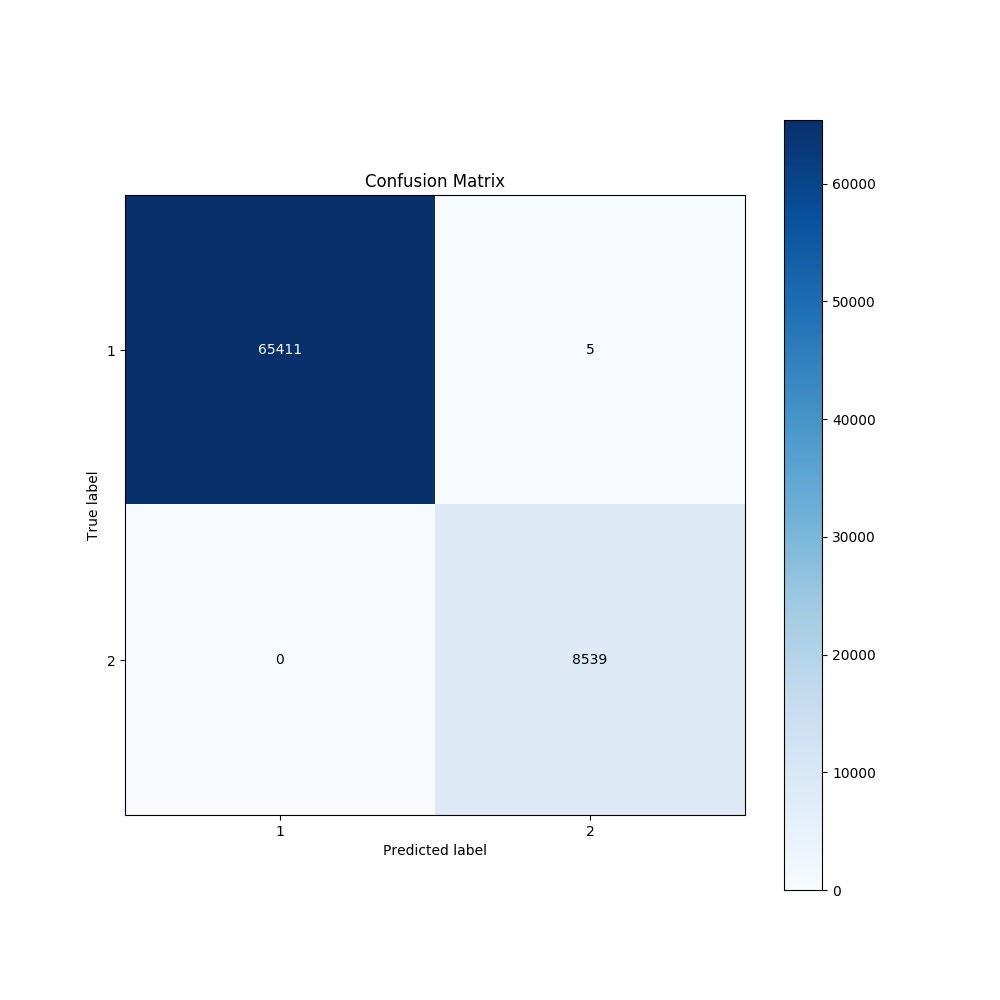

In [14]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred,figsize=(10,10))

## Classification Report

In [15]:
print(classification_report(y_test, y_pred, target_names=['Stress', 'No Stress']))

              precision    recall  f1-score   support

      Stress       1.00      1.00      1.00     65416
   No Stress       1.00      1.00      1.00      8539

    accuracy                           1.00     73955
   macro avg       1.00      1.00      1.00     73955
weighted avg       1.00      1.00      1.00     73955



## Feature Importance Chart

<IPython.core.display.Javascript object>


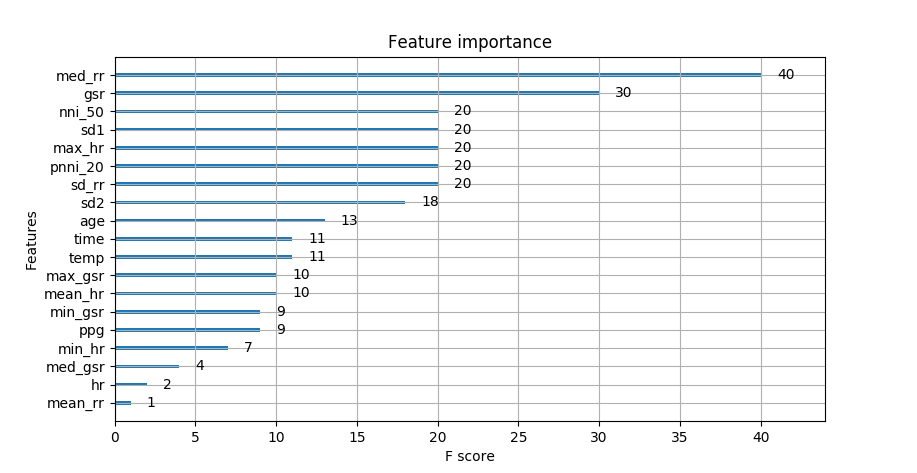

In [16]:
xg.plot_importance(clf)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()